# Unsupervised Contrastive Learning

## Defining Classes for Analysis

In [94]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import umap
import os 
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import seaborn as sns
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from statistics import mode
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import ks_2samp

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [2]:
# The TweetyClr class will initialize the folderpaths, do preprocessing of the data, and set up the data for contrastive learning

class Tweetyclr:
    def __init__(self, bird_dir, directory, num_spec, window_size, stride, analysis_path, category_colors = None):
        '''The init function should define:
            1. directory for bird
            2. directory for python files
            3. analysis path
            4. folder name 


            Additional tasks
            1. create the folder name if it does not exist already

        '''
        self.bird_dir = bird_dir
        self.directory = directory
        self.num_spec = num_spec
        self.window_size = window_size
        self.stride = stride
        self.analysis_path = analysis_path
        self.category_colors = category_colors

        folder_name = f'{analysis_path}InfoNCE_Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'
        self.folder_name = folder_name 

        # Create the folder if it doesn't already exist
        if not os.path.exists(folder_name+"/Plots/Window_Plots"):
            os.makedirs(folder_name+"/Plots/Window_Plots")
            print(f'Folder "{folder_name}" created successfully.')
        else:
            print(f'Folder "{folder_name}" already exists.')

    def first_time_analysis(self):
        files = os.listdir(self.directory)
        all_songs_data = [element for element in files if '.npz' in element] # Get the file paths of each numpy file from Yarden's data
        all_songs_data.sort()
        os.chdir(self.directory)

        # For each spectrogram we will extract
        # 1. Each timepoint's syllable label
        # 2. The spectrogram itself
        stacked_labels = [] 
        stacked_specs = []
        for i in np.arange(self.num_spec):
            # Extract the data within the numpy file. We will use this to create the spectrogram
            dat = np.load(all_songs_data[i])
            spec = dat['s']
            times = dat['t']
            frequencies = dat['f']
            labels = dat['labels']
            labels = labels.T


            # Let's get rid of higher order frequencies
            mask = (frequencies<7000)&(frequencies>500)
            masked_frequencies = frequencies[mask]

            subsetted_spec = spec[mask.reshape(mask.shape[0],),:]
            
            stacked_labels.append(labels)
            stacked_specs.append(subsetted_spec)

            
        stacked_specs = np.concatenate((stacked_specs), axis = 1)
        stacked_labels = np.concatenate((stacked_labels), axis = 0)

        # Get a list of unique categories (syllable labels)
        unique_categories = np.unique(stacked_labels)

        spec_for_analysis = stacked_specs.T
        window_labels_arr = []
        embedding_arr = []
        # Find the exact sampling frequency (the time in miliseconds between one pixel [timepoint] and another pixel)
        dx = np.diff(times)[0,0]

        # We will now extract each mini-spectrogram from the full spectrogram
        stacked_windows = []
        # Find the syllable labels for each mini-spectrogram
        stacked_labels_for_window = []
        # Find the mini-spectrograms onset and ending times 
        stacked_window_times = []

        # The below for-loop will find each mini-spectrogram (window) and populate the empty lists we defined above.
        for i in range(0, spec_for_analysis.shape[0] - self.window_size + 1, self.stride):
            # Find the window
            window = spec_for_analysis[i:i + self.window_size, :]
            # Get the window onset and ending times
            window_times = dx*np.arange(i, i + self.window_size)
            # We will flatten the window to be a 1D vector
            window = window.reshape(1, window.shape[0]*window.shape[1])
            # Extract the syllable labels for the window
            labels_for_window = stacked_labels[i:i+self.window_size, :]
            # Reshape the syllable labels for the window into a 1D array
            labels_for_window = labels_for_window.reshape(1, labels_for_window.shape[0]*labels_for_window.shape[1])
            # Populate the empty lists defined above
            stacked_windows.append(window)
            stacked_labels_for_window.append(labels_for_window)
            stacked_window_times.append(window_times)

        # Convert the populated lists into a stacked numpy array
        stacked_windows = np.stack(stacked_windows, axis = 0)
        stacked_windows = np.squeeze(stacked_windows)

        stacked_labels_for_window = np.stack(stacked_labels_for_window, axis = 0)
        stacked_labels_for_window = np.squeeze(stacked_labels_for_window)

        stacked_window_times = np.stack(stacked_window_times, axis = 0)

        # For each mini-spectrogram, find the average color across all unique syllables
        mean_colors_per_minispec = np.zeros((stacked_labels_for_window.shape[0], 3))
        for i in np.arange(stacked_labels_for_window.shape[0]):
            list_of_colors_for_row = [self.category_colors[x] for x in stacked_labels_for_window[i,:]]
            all_colors_in_minispec = np.array(list_of_colors_for_row)
            mean_color = np.mean(all_colors_in_minispec, axis = 0)
            mean_colors_per_minispec[i,:] = mean_color

        self.stacked_windows = stacked_windows
        self.stacked_labels_for_window = stacked_labels_for_window
        self.mean_colors_per_minispec = mean_colors_per_minispec
        self.stacked_window_times = stacked_window_times
        self.masked_frequencies = masked_frequencies

    def z_score(self, data):

        mean = np.mean(data, axis=1, keepdims=True)
        std = np.std(data, axis=1, keepdims=True)
            
        # # z-score each row
        zscored = (data - mean) / std

        zscored[np.isnan(zscored)] = 0 

        return zscored



    def embeddable_image(self, data, iteration_number):
        # This function will save an image for each mini-spectrogram. This will be used for understanding the UMAP plot.

    
        data.shape = (self.window_size, int(data.shape[0]/self.window_size))
        data = data.T 
        window_times = self.window_times.reshape(1, self.window_times.shape[0])
        plt.pcolormesh(window_times, self.masked_frequencies, data, cmap='jet')
        # let's save the plt colormesh as an image.
        plt.savefig(self.folder_name+'/Plots/Window_Plots/'+f'Window_{iteration_number}.png')
        plt.close()


    def compute_UMAP_decomp(self, zscored):
        # Perform a UMAP embedding on the dataset of mini-spectrograms
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(zscored)

        return embedding

    def plot_UMAP_embedding(self, embedding, mean_colors_per_minispec, filename, saveflag = False):

        # Specify an HTML file to save the Bokeh image to.
        output_file(filename=f'{self.folder_name}/Plots/{filename}.html')

        # Convert the UMAP embedding to a Pandas Dataframe
        spec_df = pd.DataFrame(embedding, columns=('x', 'y'))


        # Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
        source = ColumnDataSource(data=dict(x = embedding[:,0], y = embedding[:,1], colors=mean_colors_per_minispec))


        # Create a figure and add a scatter plot
        p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
        p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

        hover = p.select(dict(type=HoverTool))
        hover.tooltips = """
            <div>
                <h3>@x, @y</h3>
                <div>
                    <img
                        src="@image" height="100" alt="@image" width="100"
                        style="float: left; margin: 0px 15px 15px 0px;"
                        border="2"
                    ></img>
                </div>
            </div>
        """

        p.add_tools(HoverTool(tooltips="""
        """))


        # Set the image path for each data point
        # source.data['image'] = []
        # for i in np.arange(spec_df.shape[0]):
        #     source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

        show(p)

    def find_slice_actual_labels(self, stacked_labels_for_window):
        al = []
        for i in np.arange(stacked_labels_for_window.shape[0]):
            arr = stacked_labels_for_window[i,:]
            unique_elements, counts = np.unique(arr, return_counts=True)
            # print(unique_elements)
            # print(counts)
            sorted_indices = np.argsort(-counts)
            val = unique_elements[sorted_indices[0]]
            if val == 0:
                if unique_elements.shape[0]>1:
                    val = unique_elements[sorted_indices[1]]
            al.append(val)

        actual_labels = np.array(al)
        
        self.actual_labels = actual_labels

    def shuffling(self, shuffled_indices_path = None):
        if shuffled_indices_path == None:
            shuffled_indices = np.random.permutation(self.stacked_windows.shape[0])
        else:
            shuffled_indices = np.load(f'{self.folder_name}/shuffled_indices.npy')

        # Shuffle array1 using the shuffled indices
        self.stacked_windows_for_analysis = self.stacked_windows[shuffled_indices,:]

        # Shuffle array2 using the same shuffled indices
        self.stacked_labels_for_analysis= self.stacked_labels_for_window[shuffled_indices,:]

        self.mean_colors_per_minispec_for_analysis = self.mean_colors_per_minispec[shuffled_indices, :]

        self.actual_labels_for_analysis = self.actual_labels[shuffled_indices]

        self.shuffled_indices = shuffled_indices

        # Now let's identify and remove transition slices
        transition_rows = np.where(np.apply_along_axis(lambda x: len(np.unique(x)) >= 3, 1, self.stacked_labels_for_analysis))[0]

        self.stacked_windows_for_analysis_nontransitions = np.delete(self.stacked_windows_for_analysis, transition_rows, axis = 0)
        self.mean_colors_per_minispec_for_analysis_nontransitions = np.delete(self.mean_colors_per_minispec_for_analysis, transition_rows, axis = 0)
        self.stacked_labels_for_analysis_nontransitions = np.delete(self.stacked_labels_for_analysis, transition_rows, axis = 0)
        self.actual_labels_for_analysis_nontransitions = np.apply_along_axis(lambda x: mode(x), axis=1, arr=self.stacked_labels_for_analysis_nontransitions)

        self.transition_rows = transition_rows

        self.dat = self.z_score(self.stacked_windows_for_analysis_nontransitions)

    def train_test_split(self, train_split_perc, batch_size):
        # I want to make training indices to be the first 80% of the shuffled data
        split_point = int(train_split_perc*self.dat.shape[0])

        stacked_windows_train = torch.tensor(self.dat[:split_point, :])
        self.stacked_windows_train = stacked_windows_train.reshape(stacked_windows_train.shape[0], 1, 100, 151)

        stacked_labels_train = self.stacked_labels_for_analysis_nontransitions[:split_point,:]
        self.mean_colors_per_minispec_train = self.mean_colors_per_minispec_for_analysis_nontransitions[:split_point,:]
        self.actual_labels_train = torch.tensor(self.actual_labels_for_analysis_nontransitions[:split_point])
        self.stacked_labels_train = stacked_labels_train

        # The testing data will be the left-out 20%

        stacked_windows_test = torch.tensor(self.dat[split_point:, :])
        self.stacked_windows_test = stacked_windows_test.reshape(stacked_windows_test.shape[0], 1, 100, 151)

        stacked_labels_test = self.stacked_labels_for_analysis_nontransitions[split_point:,:]
        self.mean_colors_per_minispec_test = self.mean_colors_per_minispec_for_analysis_nontransitions[split_point:,:]
        self.actual_labels_test = torch.tensor(self.actual_labels_for_analysis_nontransitions[split_point:])
        self.stacked_labels_test = stacked_labels_test

        train_dataset = TensorDataset(self.stacked_windows_train, self.actual_labels_train)
        test_dataset = TensorDataset(self.stacked_windows_test, self.actual_labels_test)

        # Define batch size
        # batch_size = CFG.batch_size
        batch_size = 128

        self.batch_size = batch_size

        # Create a DataLoader
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        self.test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




TweetyNet Specification 

In [3]:
class TweetyNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=(5, 5), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(5, 5), stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(8, 1), stride=(8, 1))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(9408, 4000)
        self.fc2 = nn.Linear(4000, 1000)
        # self.fc3 = nn.Linear(100, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Encoder f
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

Data augmentation

In [4]:
class White_Noise:
    def __init__(self, noise_level):
        
        self.noise_level = noise_level
        
    def __call__(self, x):
        
        noise = torch.randn_like(x) * self.noise_level
        x = x + noise
        return x

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [309]:
class model_training:
    def __init__(self, patience, learning_rate, projection_units, num_epochs, temperature, tweetyclr_obj):
        self.patience = patience
        self.learning_rate = learning_rate
        self.projection_units = projection_units
        self.num_epochs = num_epochs 
        self.temperature = temperature
        self.tweetyclr_obj = tweetyclr_obj

    # def initializing_conv_frontend(self):

    #     if torch.cuda.is_available():
    #         device = "cuda:0"
    #     else:
    #         device = "cpu"


    #     # Check if multiple GPUs are available
    #     if torch.cuda.device_count() > 1:
    #         print(f"Using {torch.cuda.device_count()} GPUs!")
    #         # If so, wrap the model using nn.DataParallel
    #         cnn_model = nn.DataParallel(TweetyNetCNN()).double()
    #     else:
    #         cnn_model = TweetyNetCNN().double()

    #     cnn_model.to(device)  # Send model to GPU
    #     self.device = device
    # 
        # return cnn_model


    def create_embedding_from_model(self, data_loader, cnn_model, type_of_analysis, type_of_data, saveflag):
        # TYpe of analysis = ("trained", "untrained")
        cnn_model = cnn_model.to('cpu')
        cnn_model.eval()
        batch_count = 0
        for batch, lab_val in (data_loader):
            batch_count+=1
            batch_data = batch
            batch_data = batch_data.reshape(batch_data.shape[0], 1, 100, 151)

            x = cnn_model.module.conv1(batch_data.to('cpu'))
            x = cnn_model.module.relu(x)
            x = cnn_model.module.pool1(x)
            x = cnn_model.module.conv2(x)
            x = cnn_model.module.relu(x)
            x = cnn_model.module.pool2(x)
            x = torch.flatten(x, 1)
            x = cnn_model.module.relu(x)
            x = cnn_model.module.fc1(x)
            x_proj = cnn_model.module.fc2(x)
            
            x_arr = x.detach().numpy()
            x_proj_arr = x_proj.detach().numpy()

            if saveflag==True:
                np.save(f'{self.tweetyclr_obj.folder_name}/{type_of_data}_{type_of_analysis}_backbone_rep_of_batch_index_{batch_count:03}.npy', x_arr)
                np.save(f'{self.tweetyclr_obj.folder_name}/{type_of_data}_{type_of_analysis}_proj_rep_of_batch_index_{batch_count:03}.npy', x_proj_arr)



    def extract_embedding(self, type_of_analysis, type_of_data, model_layer):
        files = os.listdir(self.tweetyclr_obj.folder_name)
        if type_of_analysis == "untrained":
            if model_layer == "backbone":
                all_batches = [element for element in files if f'{type_of_data}_{type_of_analysis}_backbone_rep_of_batch_index_' in element] # Get the file paths of each numpy file from Yarden's data
            elif model_layer == "projection":
                all_batches = [element for element in files if f'{type_of_data}_{type_of_analysis}_proj_rep_of_batch_index_' in element] # Get the file paths of each numpy file from Yarden's data
        else:
            if model_layer == "backbone":
                all_batches = [element for element in files if f'{type_of_data}_{type_of_analysis}_backbone_rep_of_batch_index_' in element and 'untrained' not in element] 
            elif model_layer == "projection":
                all_batches = [element for element in files if f'{type_of_data}_{type_of_analysis}_proj_rep_of_batch_index_' in element and 'untrained' not in element]   

        all_batches.sort()

        if model_layer == "backbone":
            embedding_arr = np.empty((0, 4000))
        elif model_layer == "projection":
            embedding_arr = np.empty((0, 1000))

        for i in all_batches:
            arr = np.load(f'{self.tweetyclr_obj.folder_name}/{i}')
            embedding_arr = np.concatenate((embedding_arr, arr))

        return embedding_arr

    def train(self, cnn_model, optimizer, wn, device):
        history = defaultdict(list)
        torch.cuda.empty_cache()
        best_val_loss = float('inf')
        epochs_no_improve = 0

        for epoch in np.arange(self.num_epochs):
            running_loss = 0.0
            for inputs, lab_vals in (self.tweetyclr_obj.train_dataloader):
                # inputs = inputs.to(device)
                # labels = labels.to(device)
                
                # Apply augmentations to dataset 
                
                augmented_data_1 = wn(inputs)
                
                total_data = torch.concatenate((inputs, augmented_data_1))
                embedding = cnn_model(total_data.to(device))
                
                cos_sim = F.cosine_similarity(embedding.unsqueeze(1), embedding.unsqueeze(0), dim=2)
                
                # Mask out cosine similarity to itself
                self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
                cos_sim = cos_sim.masked_fill_(self_mask, -9e15)
                # Find positive example -> batch_size//2 away from the original example
                pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
                                
                cos_sim = cos_sim / self.temperature
                
                nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
                nll = nll.mean()

                optimizer.zero_grad()
                nll.backward()
                optimizer.step()
                running_loss += nll.item()*total_data.size(0)

            epoch_loss = running_loss/self.tweetyclr_obj.stacked_windows_train.shape[0]         
            history['train' + ' loss'].append(epoch_loss)
            
            # At the end of each epoch, validate the model
            cnn_model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labs in self.tweetyclr_obj.test_dataloader:
                    # inputs = inputs.to(device)

                    # Apply augmentations to dataset 
                
                    augmented_data_1 = wn(inputs)
                
                    total_data = torch.concatenate((inputs, augmented_data_1))

                    embedding = cnn_model(total_data.to(device))
                
                    cos_sim = F.cosine_similarity(embedding.unsqueeze(1), embedding.unsqueeze(0), dim=2)
                    
                    # Mask out cosine similarity to itself
                    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
                    cos_sim = cos_sim.masked_fill_(self_mask, -9e15)
                    # Find positive example -> batch_size//2 away from the original example
                    pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
                                        
                    cos_sim = cos_sim / self.temperature
                    
                    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
                    nll = nll.mean()
                    val_loss += nll.item()

            # Average validation loss
            val_loss = val_loss / len(self.tweetyclr_obj.test_dataloader)
            history['validation' + ' loss'].append(val_loss)
            

            print(f'Epoch {epoch}: Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')


            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                # We will save the models at the epochs where we had improved validation loss. 
                torch.save(cnn_model.state_dict(), f'{self.tweetyclr_obj.folder_name}/cnn_model_epoch_{epoch}.pt')
            else:
                epochs_no_improve += 1

            # Early stopping
            if epochs_no_improve == self.patience:
                print(f'Early stopping at epoch {epoch}!')
                break

        return cnn_model, history

    def train_downstream_classifier(self, clf, model_embedding_train, model_embedding_test, labels_train, labels_test, criterion, optimizer, num_epochs):

        unique_labels = np.unique(self.tweetyclr_obj.actual_labels_for_analysis_nontransitions)

        # Create a mapping from unique labels to consecutive indices
        label_mapping = {label.item(): index for index, label in enumerate(unique_labels)}

        # Map the original labels to consecutive indices
        mapped_labels_train = torch.tensor([label_mapping.get(label.item(), -1) for label in self.tweetyclr_obj.actual_labels_train], dtype=torch.long)
        mapped_labels_test = torch.tensor([label_mapping.get(label.item(), -1) for label in self.tweetyclr_obj.actual_labels_test], dtype=torch.long)

        # Filter out unmapped labels
        valid_indices_train = mapped_labels_train != -1
        valid_indices_test = mapped_labels_test != -1

        mapped_labels_train = mapped_labels_train[valid_indices_train]
        mapped_labels_test = mapped_labels_test[valid_indices_test]
        
        model = clf
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        model.train()
        epoch_loss_train = []
        epoch_loss_test = []
        for epoch in range(num_epochs):
            # Convert data to PyTorch tensors
            inputs = torch.tensor(model_embedding_train, dtype=torch.float32)
            labels = mapped_labels_train
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            
            # Compute loss
            loss_train = criterion(outputs, labels)
            epoch_loss_train.append(loss_train.item())
            
            # Backward pass and optimization
            loss_train.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                inputs = torch.tensor(model_embedding_test, dtype=torch.float32)
                labels = mapped_labels_test
                # Forward pass
                outputs = model(inputs)
                
                # Compute loss
                loss_test = criterion(outputs, labels)
                epoch_loss_test.append(loss_test.item())

            print(f'Epoch {epoch}: Training Loss: {loss_train:.4f}, Validation Loss: {loss_test:.4f}')

        return model, epoch_loss_train, epoch_loss_test

    def get_probabilities_from_classifier(self, data, model):
        with torch.no_grad():
            outputs = model(torch.tensor(data, dtype=torch.float32))
            probs = nn.Softmax(dim=1)(outputs)
            
        return probs.numpy()
 

## Running the Analysis

Each model will have its own TweetyClr class. Let's define one analysis where we use the augmentation parameter we have currently been using. Let's also test it out on data from 2 songs for now (as a test bed)

### Toy Example: 50 songs

In [182]:
# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'

# Parameters we set
num_spec = 50
window_size = 100
stride = 10

# Load in the category colors that we ran for the real canary data 
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/InfoNCE_Num_Spectrograms_100_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as f:
    # load the dictionary from the file using pickle.load()
    category_colors = pickle.load(f)  

simple_tweetyclr = Tweetyclr(bird_dir, directory, num_spec, window_size, stride, analysis_path, category_colors)

Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/InfoNCE_Num_Spectrograms_50_Window_Size_100_Stride_10" created successfully.


Create the spectrogram slice windows and z-score

In [183]:
simple_tweetyclr.first_time_analysis()
z_scored_stacked_windows = simple_tweetyclr.z_score(simple_tweetyclr.stacked_windows)

/tmp/ipykernel_809839/1686417045.py:130: RuntimeWarning: invalid value encountered in true_divide
  zscored = (data - mean) / std


In [184]:
z_scored_stacked_windows.shape

(22788, 15100)

Compute the UMAP embedding and plot it

In [159]:
umap_embed = simple_tweetyclr.compute_UMAP_decomp(z_scored_stacked_windows)

In [160]:
simple_tweetyclr.plot_UMAP_embedding(umap_embed, simple_tweetyclr.mean_colors_per_minispec, '', saveflag = False)

OUr first analysis will exclude transition states. Let's find them and remove them from our data structures

In [185]:
simple_tweetyclr.find_slice_actual_labels(simple_tweetyclr.stacked_labels_for_window)

In [187]:
np.unique(simple_tweetyclr.actual_labels).shape

(20,)

Shuffle our data

In [188]:
simple_tweetyclr.shuffling(shuffled_indices_path = None)

/tmp/ipykernel_809839/1686417045.py:130: RuntimeWarning: invalid value encountered in true_divide
  zscored = (data - mean) / std


Create training and testing data

In [189]:
simple_tweetyclr.train_test_split(0.8, 128)

Initialize model and augmentation objects

In [190]:
cnn_model = TweetyNetCNN()
noise_level = 1
wn = White_Noise(noise_level)

In [191]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"


# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # If so, wrap the model using nn.DataParallel
    cnn_model = nn.DataParallel(TweetyNetCNN()).double()
else:
    cnn_model = TweetyNetCNN().double()

cnn_model = cnn_model.to(device)  # Send model to GPU

Using 2 GPUs!


I want to run an analysis on the projection layer. Therefore the input size to my downstream classifier will be the size of the projection 

In [192]:
np.unique(simple_tweetyclr.actual_labels_for_analysis_nontransitions).shape[0]

18

In [193]:
clf = SimpleMLP(input_size=1000, hidden_size=500, num_classes=22)

In [310]:
patience = 20
learning_rate = 0.001
projection_units = 1000
num_epochs = 100
temperature = 0.07

training_obj = model_training(patience, learning_rate, projection_units, num_epochs, temperature, simple_tweetyclr)


In [195]:
training_obj.create_embedding_from_model(simple_tweetyclr.train_dataloader, cnn_model, 'untrained', 'training_data',True)

In [196]:
proj_arr_training = training_obj.extract_embedding('untrained', 'training_data','projection')

In [197]:
proj_arr_training.shape

(16832, 1000)

In [198]:
np.save(f'{simple_tweetyclr.folder_name}/training_data_untrained_proj_arr.npy', proj_arr_training)

In [199]:
training_obj.create_embedding_from_model(simple_tweetyclr.test_dataloader, cnn_model, 'untrained', 'testing_data',True)

In [200]:
proj_arr_testing = training_obj.extract_embedding('untrained', 'testing_data','projection')

In [201]:
proj_arr_testing.shape

(4209, 1000)

In [202]:
np.save(f'{simple_tweetyclr.folder_name}/testing_data_untrained_proj_arr.npy', proj_arr_testing)

In [203]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"


# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # If so, wrap the model using nn.DataParallel
    cnn_model = nn.DataParallel(TweetyNetCNN()).double()
else:
    cnn_model = TweetyNetCNN().double()

cnn_model = cnn_model.to(device)  # Send model to GPU

Using 2 GPUs!


In [204]:
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay = 1e-5)

cnn_model, history = training_obj.train(cnn_model, optimizer, wn, device)

Epoch 0: Training Loss: 4.1332, Validation Loss: 0.9835
Epoch 1: Training Loss: 1.4225, Validation Loss: 0.4991
Epoch 2: Training Loss: 0.6888, Validation Loss: 0.3041
Epoch 3: Training Loss: 0.4712, Validation Loss: 0.2494
Epoch 4: Training Loss: 0.3950, Validation Loss: 0.2282
Epoch 5: Training Loss: 0.3562, Validation Loss: 0.2173
Epoch 6: Training Loss: 0.3328, Validation Loss: 0.2019
Epoch 7: Training Loss: 0.3130, Validation Loss: 0.1941
Epoch 8: Training Loss: 0.2996, Validation Loss: 0.1880
Epoch 9: Training Loss: 0.2952, Validation Loss: 0.1878
Epoch 10: Training Loss: 0.2895, Validation Loss: 0.1859
Epoch 11: Training Loss: 0.2818, Validation Loss: 0.1817
Epoch 12: Training Loss: 0.2787, Validation Loss: 0.1779
Epoch 13: Training Loss: 0.2731, Validation Loss: 0.1746
Epoch 14: Training Loss: 0.2734, Validation Loss: 0.1765
Epoch 15: Training Loss: 0.2698, Validation Loss: 0.1706
Epoch 16: Training Loss: 0.2667, Validation Loss: 0.1713
Epoch 17: Training Loss: 0.2658, Validati

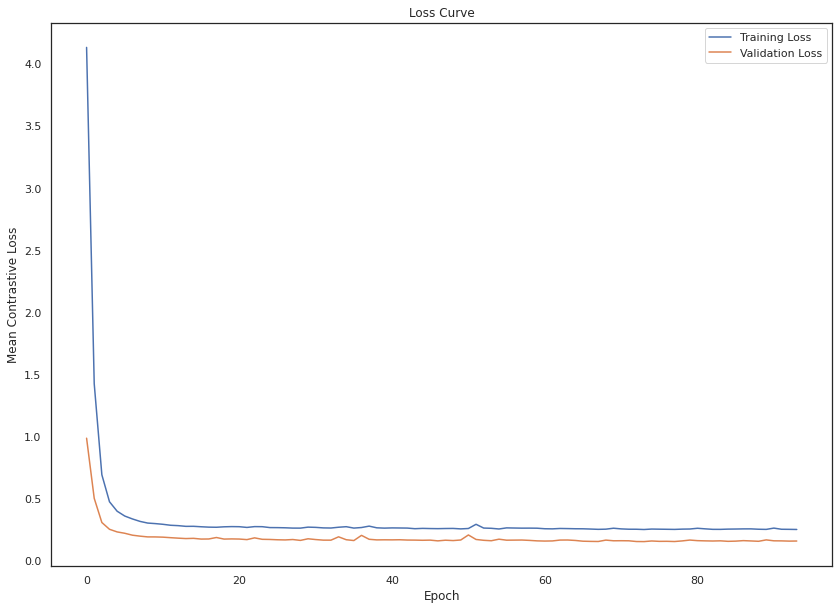

In [205]:
plt.figure()
plt.plot(history['train' + ' loss'], label = 'Training Loss')
plt.plot(history['validation' + ' loss'], label = 'Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Mean Contrastive Loss")
plt.legend()
plt.savefig(f'{simple_tweetyclr.folder_name}/UCL_Loss_Curve.png', dpi=300) 

In [206]:
training_obj.create_embedding_from_model(simple_tweetyclr.train_dataloader, cnn_model, 'trained', 'training_data', True)

In [207]:
proj_arr_training_trained = training_obj.extract_embedding('trained', 'training_data','projection')

In [208]:
proj_arr_training_trained.shape

(16832, 1000)

In [209]:
np.save(f'{simple_tweetyclr.folder_name}/training_data_trained_proj_arr.npy', proj_arr_training_trained)

In [210]:
a = simple_tweetyclr.compute_UMAP_decomp(proj_arr_training_trained)

In [211]:
simple_tweetyclr.plot_UMAP_embedding(a, simple_tweetyclr.mean_colors_per_minispec_train, '', saveflag = False)

In [212]:
training_obj.create_embedding_from_model(simple_tweetyclr.test_dataloader, cnn_model, 'trained', 'testing_data',True)

In [213]:
proj_arr_testing = training_obj.extract_embedding('trained', 'testing_data','projection')

In [214]:
proj_arr_testing.shape

(4209, 1000)

In [215]:
np.save(f'{simple_tweetyclr.folder_name}/testing_data_untrained_proj_arr.npy', proj_arr_testing)

Downstream Classifier

In [235]:
scaler = StandardScaler()
X_train = scaler.fit_transform(proj_arr_training_trained)
X_test = scaler.fit_transform(proj_arr_testing)

In [353]:
clf = SimpleMLP(input_size=1000, hidden_size=500, num_classes=18)

In [355]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=0.001)
num_epochs = 1
clf, epoch_loss_train, epoch_loss_test = training_obj.train_downstream_classifier(clf, X_train, X_test, simple_tweetyclr.actual_labels_train.clone().detach().numpy(), simple_tweetyclr.actual_labels_test.clone().detach().numpy(), criterion, optimizer, num_epochs)

Epoch 0: Training Loss: 2.9777, Validation Loss: 1.7665


In [356]:
# def get_probabilities(data, model):
#     with torch.no_grad():
#         outputs = model(torch.tensor(data, dtype=torch.float32))
#         probs = nn.Softmax(dim=1)(outputs)
#     return probs.numpy()

# Get probabilities for the test set
training_probabilities = training_obj.get_probabilities_from_classifier(X_train, clf)
testing_probabilities = training_obj.get_probabilities_from_classifier(X_test, clf)

Confusion Matrix

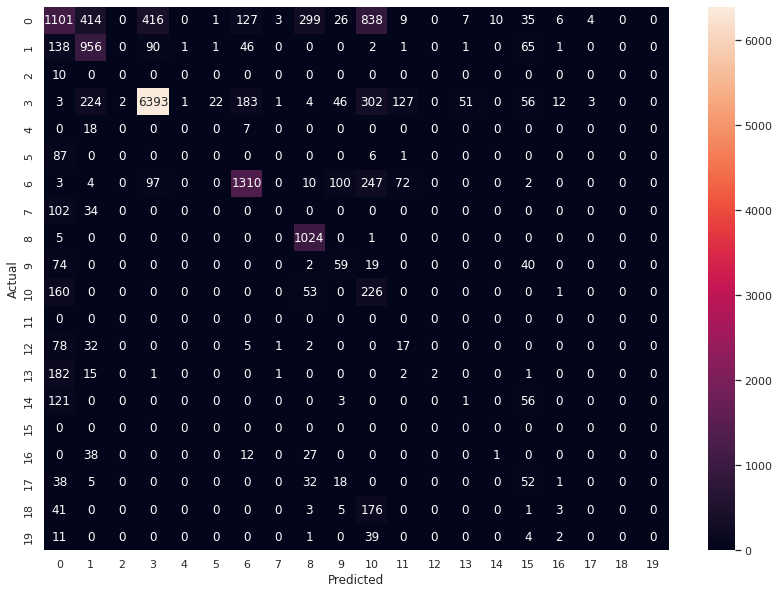

In [357]:
y_pred_training = np.argmax(training_probabilities, axis = 1)
cm = confusion_matrix(simple_tweetyclr.actual_labels_train, y_pred_training)
# Optionally, visualize the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

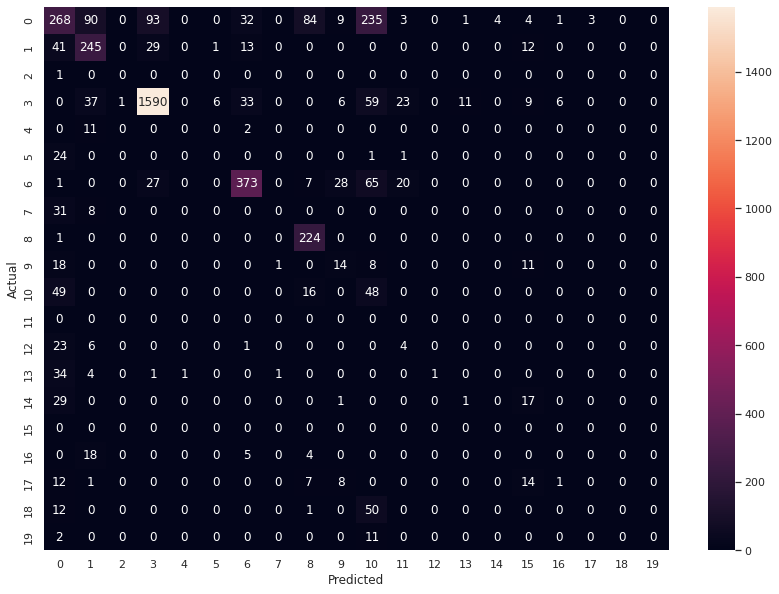

In [358]:
y_pred_testing = np.argmax(testing_probabilities, axis = 1)
cm = confusion_matrix(simple_tweetyclr.actual_labels_test, y_pred_testing)
# Optionally, visualize the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Base Accuracy values

In [359]:
training_acc = np.mean(y_pred_training == simple_tweetyclr.actual_labels_train.clone().detach().numpy())
training_acc

0.6576164448669202

In [360]:
testing_acc = np.mean(y_pred_testing == simple_tweetyclr.actual_labels_test.clone().detach().numpy())
testing_acc

0.6562128771679734

In [361]:
def compute_ks_for_class(probabilities, true_labels, class_label):
    """
    Compute the KS value for a specific class in a one-vs-rest manner.
    """
    # Consider the class as positive and rest as negative
    positive_scores = probabilities[true_labels == class_label]
    negative_scores = probabilities[true_labels != class_label]
    
    # Compute KS value using scipy's ks_2samp
    ks_statistic, _ = ks_2samp(positive_scores, negative_scores)
    
    return ks_statistic


In [362]:
unique_labels = np.unique(simple_tweetyclr.actual_labels_for_analysis_nontransitions)

# Create a mapping from unique labels to consecutive indices
label_mapping = {label.item(): index for index, label in enumerate(unique_labels)}

# Map the original labels to consecutive indices
mapped_labels_train = torch.tensor([label_mapping.get(label.item(), -1) for label in simple_tweetyclr.actual_labels_train], dtype=torch.long)
mapped_labels_test = torch.tensor([label_mapping.get(label.item(), -1) for label in simple_tweetyclr.actual_labels_test], dtype=torch.long)

# Filter out unmapped labels
valid_indices_train = mapped_labels_train != -1
valid_indices_test = mapped_labels_test != -1

mapped_labels_train = mapped_labels_train[valid_indices_train]
mapped_labels_test = mapped_labels_test[valid_indices_test]

In [363]:
torch.unique(mapped_labels_train)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [364]:
n_classes = 22 # number of syllables in dataset
ks_values = [] 

for i in np.arange(torch.unique(mapped_labels_train).shape[0]):
    ks_val = compute_ks_for_class(training_probabilities[:, i], mapped_labels_train.clone().detach().numpy(), i)
    ks_values.append(ks_val)

# ks_values = [compute_ks_for_class(training_probabilities[:, i], simple_tweetyclr.actual_labels_train.clone().detach().numpy(), i) for i in np.arange(torch.unique(mapped_labels_train).shape[0])]

In [365]:
ks_values

[0.5663365867933623,
 0.7108074852399053,
 0.5142075853049578,
 0.8351050419386156,
 0.296866781698102,
 0.22957444266200244,
 0.6692563365214623,
 0.6117844358634685,
 0.9584630432672281,
 0.9203109761160331,
 0.8045010870047473,
 0.8183781074000873,
 0.8078695514770738,
 0.7730523045253699,
 0.673290419739029,
 0.8666366193297966,
 0.8519831345258538,
 0.5921907600596126]

Let's do a ROC curve for each class vs the rest

In [366]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(mapped_labels_train.clone().detach().numpy())
y_onehot = label_binarizer.transform(mapped_labels_train.clone().detach().numpy())
y_onehot.shape  # (n_samples, n_classes)

(16832, 18)

In [367]:
def find_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # Value not found

In [368]:
found_key

12

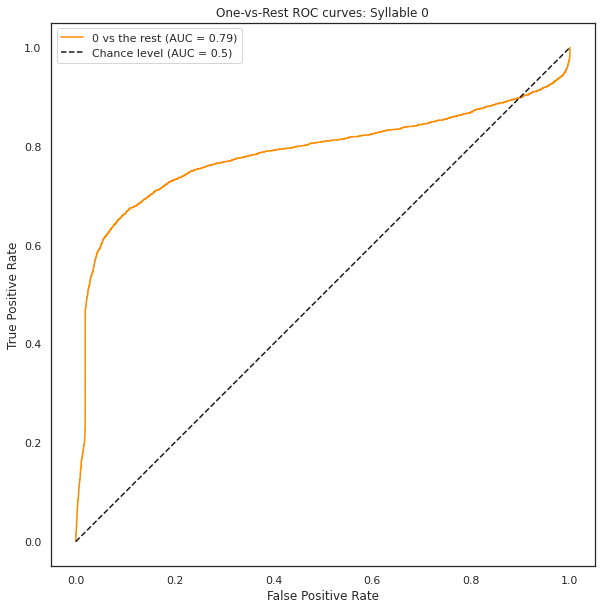

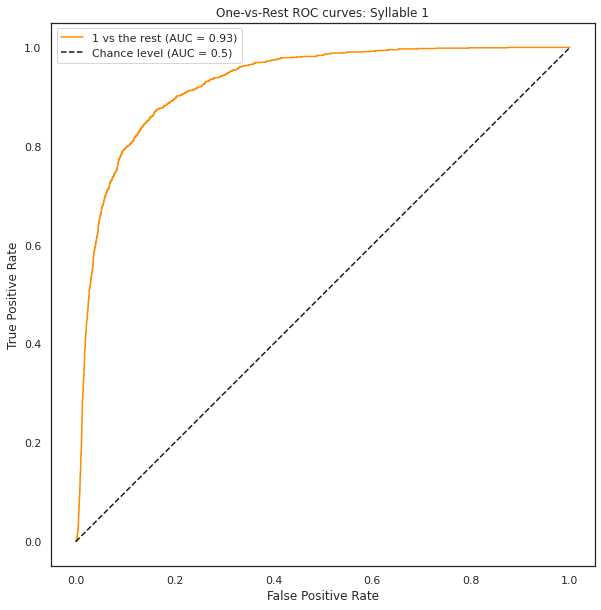

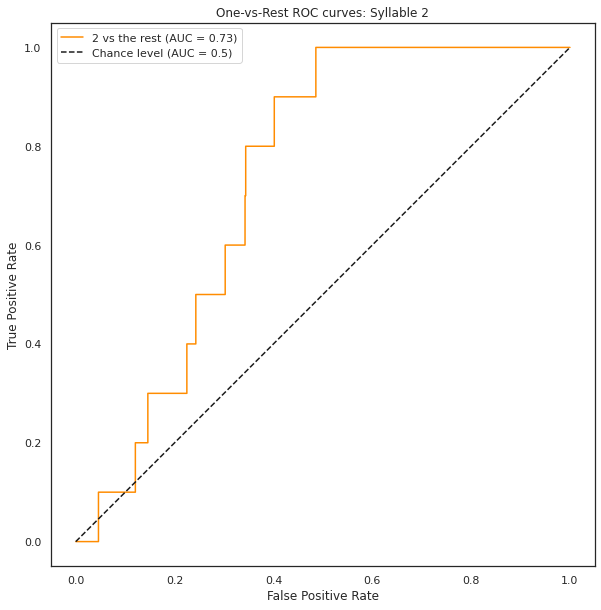

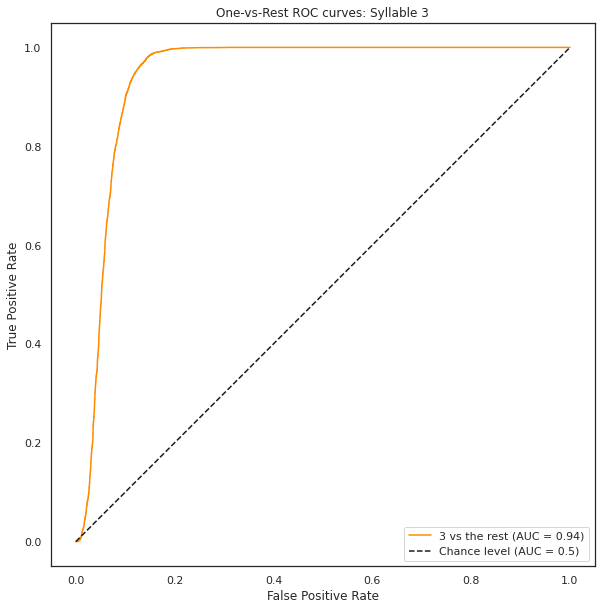

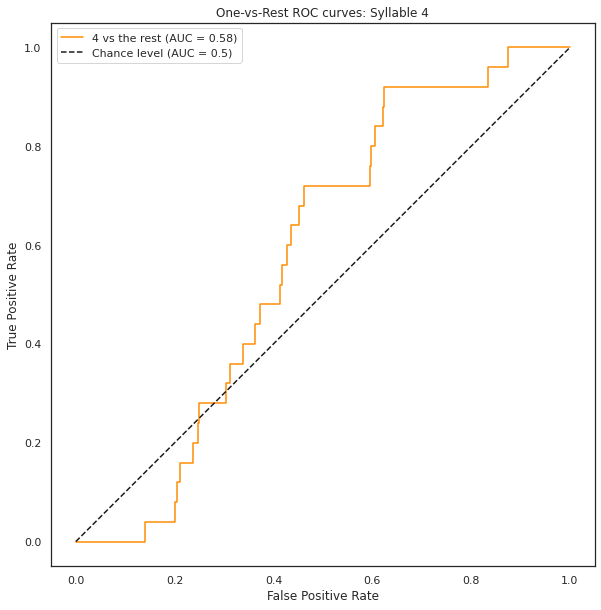

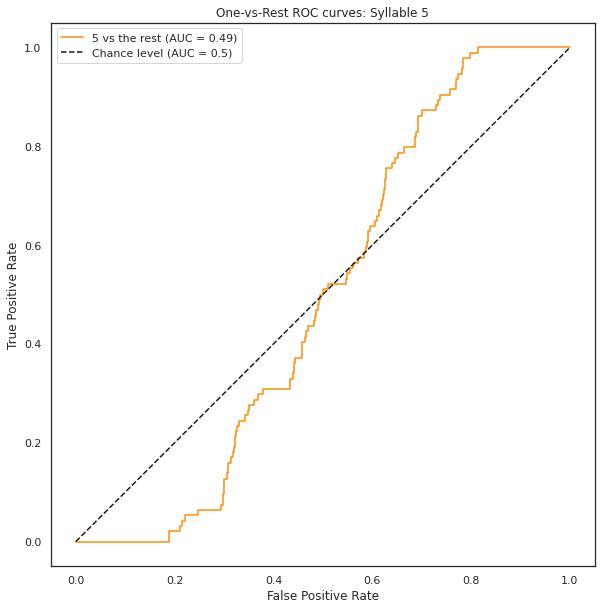

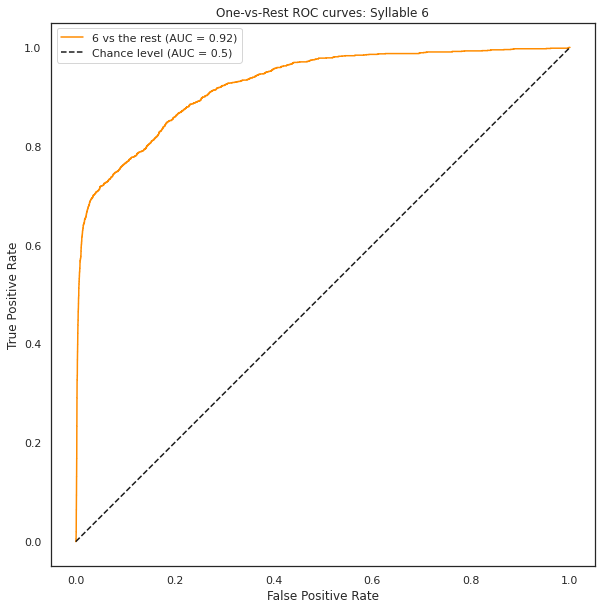

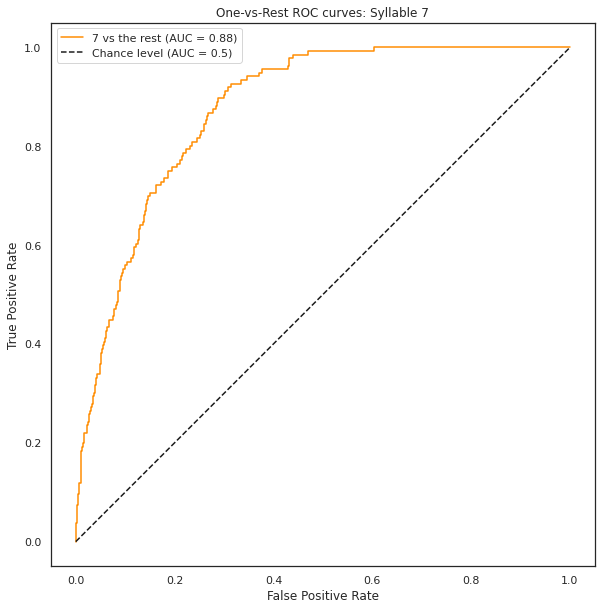

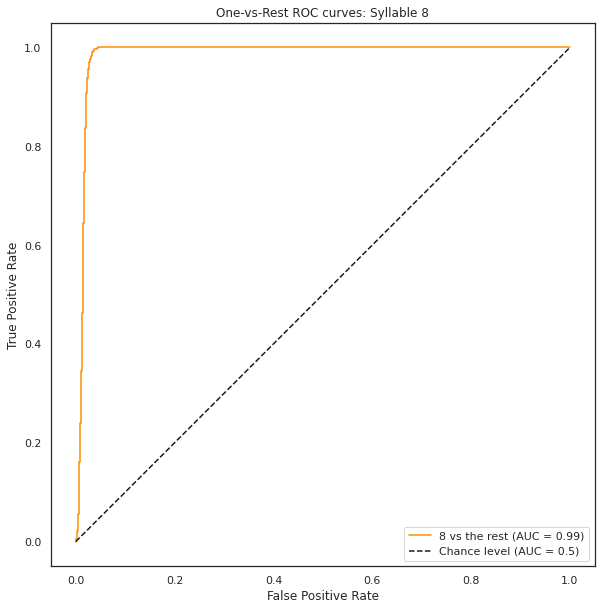

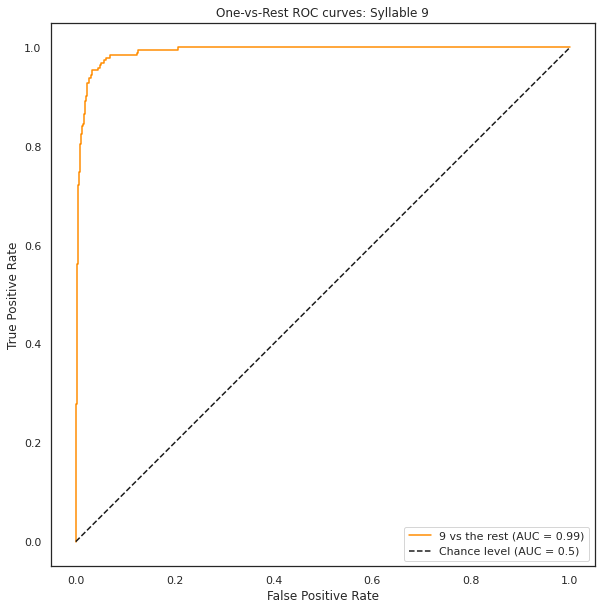

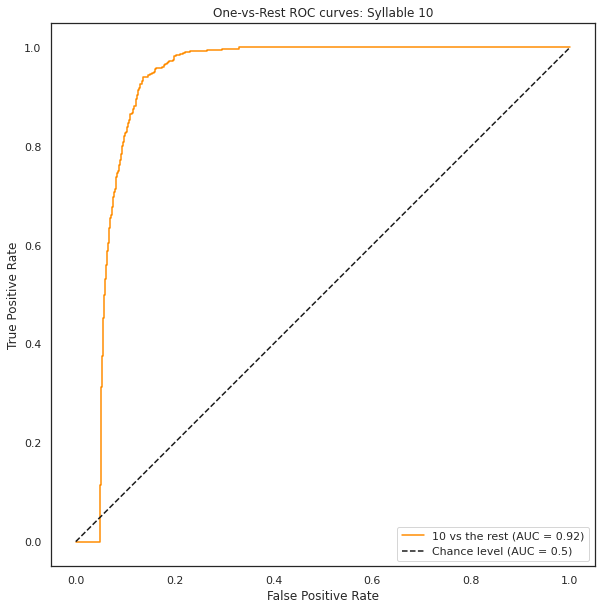

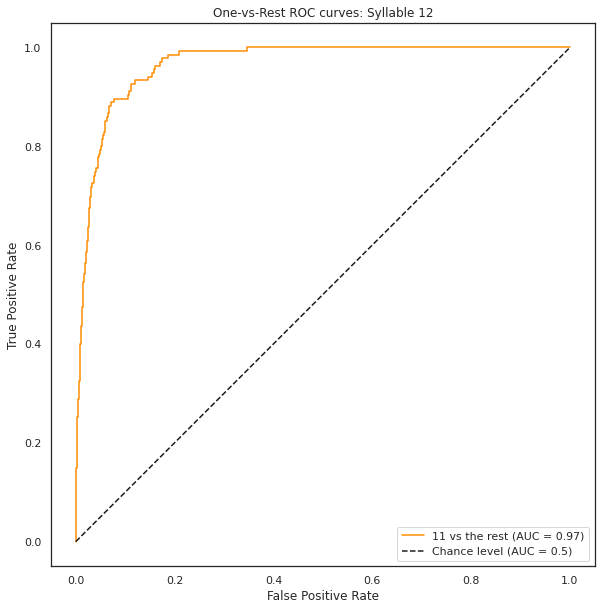

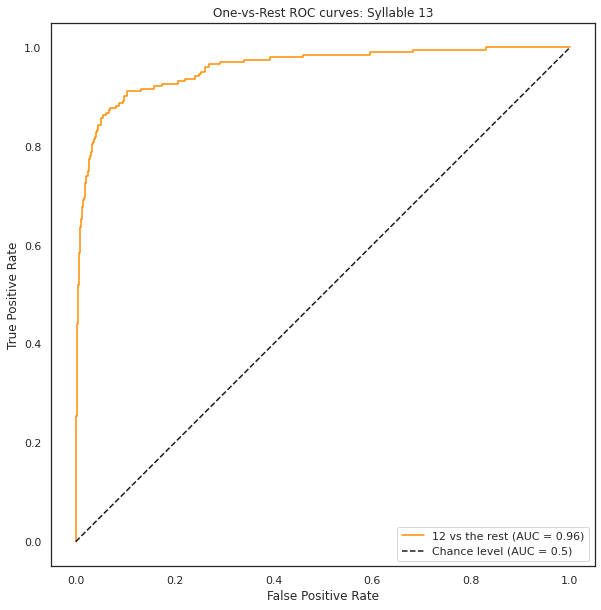

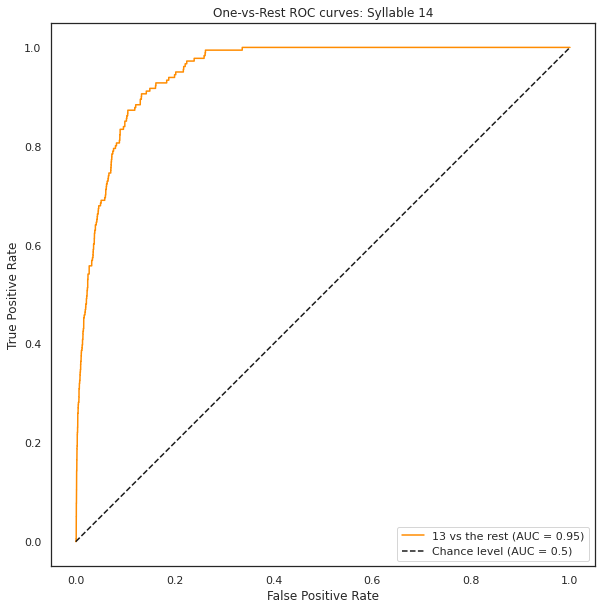

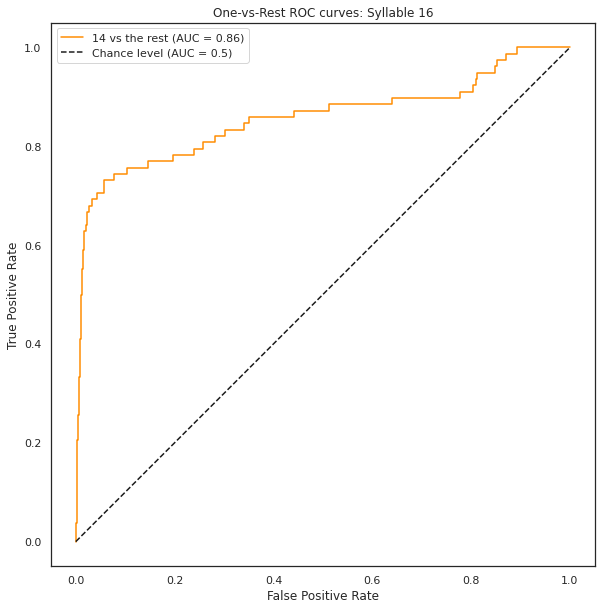

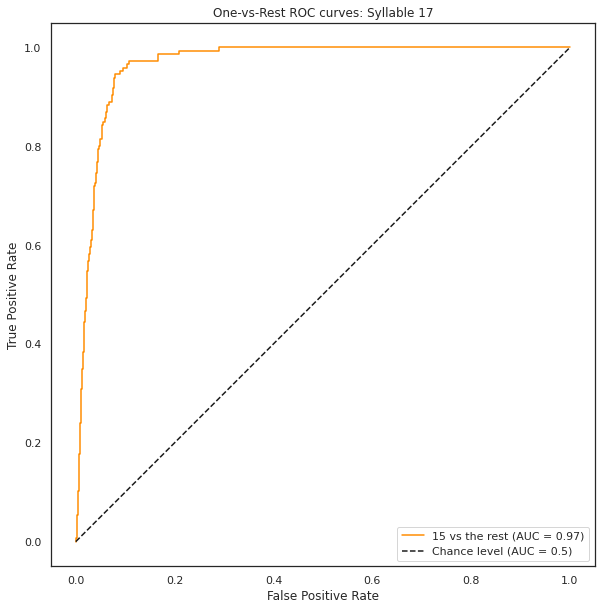

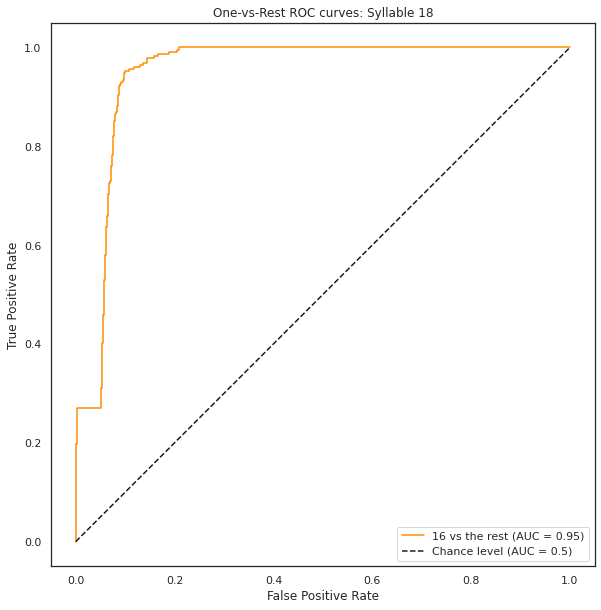

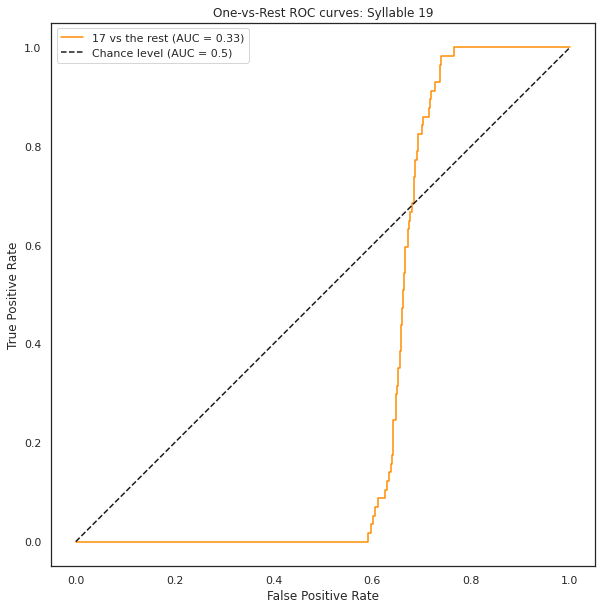

In [369]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

auc_list = []

for class_id in np.arange(torch.unique(mapped_labels_train).clone().detach().numpy().shape[0]):

    RocCurveDisplay.from_predictions(
        y_onehot[:, class_id],
        training_probabilities[:, class_id],
        name=f"{class_id} vs the rest",
        color="darkorange",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves: Syllable {find_key_by_value(label_mapping , class_id)}")
    plt.legend()
    plt.show()

    auc_value = roc_auc_score(y_onehot[:, class_id], training_probabilities[:, class_id])
    auc_list.append(auc_value)


In [372]:
u,c = np.unique(mapped_labels_train.clone().detach().numpy(), return_counts = True)
model_results = pd.DataFrame(np.concatenate((u.reshape(u.shape[0],1), c.reshape(c.shape[0],1), np.array(ks_values).reshape(len(ks_values),1)), axis = 1))
model_results.columns = ['Syllable_Label', 'Syllable_Frequency', 'OVr_KS_Value']
model_results['Percentage_of_whole_dataset'] = model_results['Syllable_Frequency']/model_results['Syllable_Frequency'].sum()
model_results

,Syllable_Label,Syllable_Frequency,OVr_KS_Value,Percentage_of_whole_dataset
0,0.0,3296.0,0.566337,0.195817
1,1.0,1302.0,0.710807,0.077353
2,2.0,10.0,0.514208,0.000594
3,3.0,7430.0,0.835105,0.441421
4,4.0,25.0,0.296867,0.001485
5,5.0,94.0,0.229574,0.005585
6,6.0,1845.0,0.669256,0.109613
7,7.0,136.0,0.611784,0.008080
8,8.0,1030.0,0.958463,0.061193
9,9.0,194.0,0.920311,0.011526


Let's see the correspondence between the KS values and the AUC values

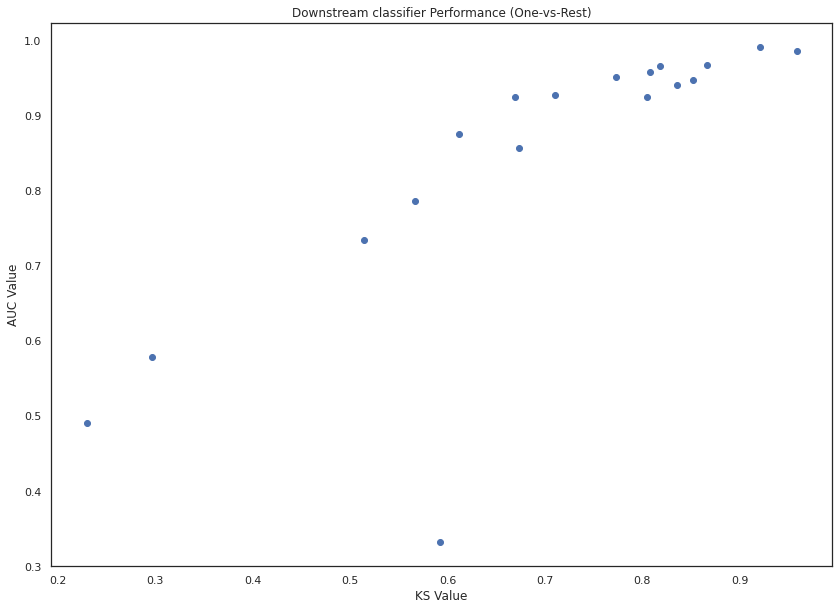

In [373]:
plt.figure()
plt.title("Downstream classifier Performance (One-vs-Rest)")
plt.xlabel("KS Value")
plt.ylabel("AUC Value")
plt.scatter(ks_values, auc_list)

Is there a relationship between class frequency and classifier performance? 

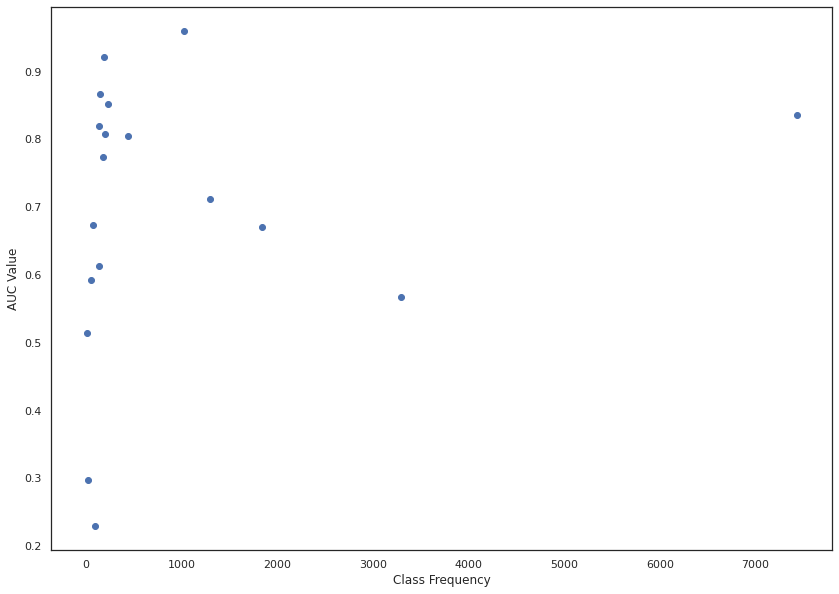

In [374]:
plt.figure()
# plt.title("Downstream classifier Performance (One-vs-Rest)")
plt.xlabel("Class Frequency")
plt.ylabel("AUC Value")
plt.scatter(c, ks_values)

### Synthetic Song

In [ ]:
# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/'

# Parameters we set
num_spec = 50
window_size = 100
stride = 10

# Load in the category colors that we ran for the real canary data 
with open('/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/InfoNCE_Num_Spectrograms_100_Window_Size_100_Stride_10/category_colors.pkl', 'rb') as f:
    # load the dictionary from the file using pickle.load()
    category_colors = pickle.load(f)  

simple_tweetyclr = Tweetyclr(bird_dir, directory, num_spec, window_size, stride, analysis_path, category_colors)